In [4]:
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install typeguard
!git clone https://github.com/fastai/fastai_dev.git

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 21kB/s 
     |████████████████████████████████| 8.8MB 2.3MB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0
Cloning into 'fastai_dev'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 22310 (delta 102), reused 112 (delta 62), pack-reused 22138
Receiving objects: 100% (22310/22310), 496.47 MiB | 33.22 MiB/s, done.
Resolving deltas: 100% (14890/14890), done.


In [5]:
%cd fastai_dev/dev

/content/fastai_dev/dev


In [0]:
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import *

In [23]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]; fn

PosixPath('/content/fastai_dev/dev/data/mnist_tiny/train/3/8729.png')

In [24]:
img = PILImage.create(fn); img


In [25]:
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 28, 28]), local.data.transform.TensorImage)

In [26]:
lbl = parent_label(fn); lbl


'3'

In [27]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

0

In [28]:
lbld = tcat.decode(lbl)
lbld

'3'

In [29]:
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn)
img.shape

torch.Size([3, 28, 28])

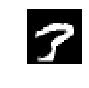

In [30]:
pipe.show(img, figsize=(1,1), cmap='Greys');


In [31]:
type(img)


local.data.transform.TensorImage

In [0]:
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.data.block import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

In [0]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = GrandparentSplitter(valid_name='val')(items)

In [0]:
tfms = [PILImage.create, [parent_label, Categorize()]]
ds_img_tfms = [ToTensor(), PILFlip(0.5), RandomResizedCrop(128, min_scale=0.35)]

In [0]:
dsrc = DataSource(items, tfms, filts=split_idx)

In [0]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [0]:
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dbch = dsrc.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=64, num_workers=0)

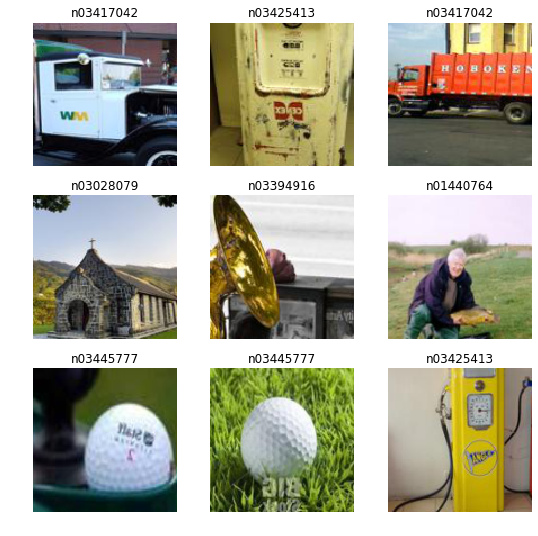

In [12]:
dbch.show_batch(max_n=9)

In [0]:
imagenette = DataBlock(ts=(PILImage, Category), 
                       get_items=get_image_files, 
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_y=parent_label)

In [14]:
imagenette.default_type_tfms,imagenette.default_ds_tfms,imagenette.default_dl_tfms


((#2) [(#1) [<bound method PILBase.create of <class 'local.vision.core.PILImage'>>],(#1) [<class 'local.data.core.Categorize'>]],
 (#1) [ToTensor: False {'PILMask': 'encodes', 'PILImageBW': 'encodes', 'PILImage': 'encodes'} {}],
 (#2) [Cuda: False {'object': 'encodes'} {'object': 'decodes'},ByteToFloatTensor: True {'TensorMask': 'encodes', 'TensorImage': 'encodes'} {'TensorImage': 'decodes'}])

In [0]:
dbch = imagenette.databunch(source, bs=64, num_workers=8, ds_tfms=ds_img_tfms, dl_tfms=Normalize(*imagenet_stats))

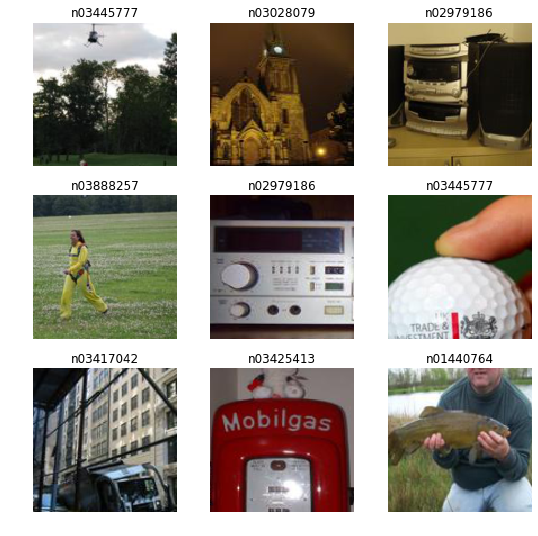

In [16]:
dbch.show_batch(max_n=9)


In [0]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [MixedPrecision]
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [0]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)


In [0]:
class LabelSmoothingCrossEntropy(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction  
    
    def forward(self, output, target):
        c = output.size()[-1]  
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

In [0]:
learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)

In [21]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,time
0,1.724476,1.389806,0.640000,00:43
